# An implementation of the DeerNet neural network in JAX
This notebook describes an implementation of the neural network DeerNet that was developed by Worswick and colleagues in 2018 and described [here](https://www.science.org/doi/10.1126/sciadv.aat5218). Whereas the original network ensemble was implemented in Matlab, the implementation below is in Python using the Jax library.

-------
#### What are DEER data?
Four-pulse Double Electron-Electron Resonance is a specific type of pulse Electron Paramagnetic Resonance Spectroscopy (EPR; also called Electron Spin Resonance, ESR) that resolve distance distributions between unpaired electrons up to 80 Å. The experimental readout is in the time-domain, which must be converted to the distance domain. This transformation is mathematically challenging and can be achieved using one of several methods (example discussions can be found [here](https://pubmed.ncbi.nlm.nih.gov/34529007/), [here](https://pubmed.ncbi.nlm.nih.gov/34568875/), and [here](https://pubmed.ncbi.nlm.nih.gov/32614584/)).

#### What is the architecture of the original DeerNet?
The DeerNet architecture is a relatively simple multilayer perceptron consisting of six fully-connected layers that alternate with hyperbolic tangent activations. The final layer is a sigmoid activation layer that enforces the target distribution's nonnegativity. A four-layer example is shown below.

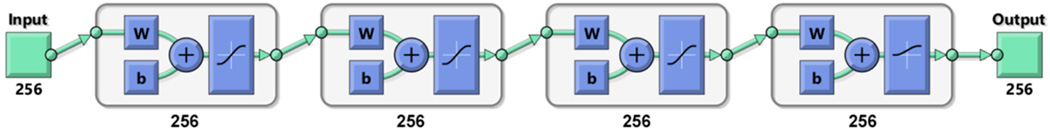

**Other remarks:**

This implementation makes a few modifications to the method:
* We are only training one network. The original uses an ensemble to compute uncertainty statistics.
* All DEER traces used here are 256 time points long. In the paper, the Savitsky-Golay filter was applied to longer DEER traces (up to 1024 time points) in order to take advantage of the extra data. Here, we skip that step and instead use 256 time points across all training data.
* Exchange coupling has been omitted due its absence from the deerlab kernel method.
* The standard deviation was set to a quarter of the average distance.. This is instead of setting the width at half-max to half the average distance.
* The [ADAM optimizer](https://arxiv.org/abs/1412.6980v8) was used here.

In [ ]:
!pip install deerlab

import dataclasses
import deerlab as dl
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.stats import skewnorm

## I. Define parameters and hyperparameters

In [ ]:
lr = 1e-4   # Learning rate
n_samples = 20000  # Number of total samples
frac_train = 0.7  # Fraction of simulated data used to train
scale = np.sqrt( 2 / 512 )  # Xavier scaling factor when initializing weights
batch_size = 64   # Number of samples to pass at a time

rseed = 0   # Random seed for pseudo-random number generator
key = jax.random.PRNGKey( rseed )   # Random number generator

## II. Simulate the dataset

Here we simulate the DEER data used in this study. The original training, validation, and test data consisted of ~100k DEER traces that were simulated using the Matlab program [Spinach](http://spindynamics.org/group/?page_id=12). Here, we will instead use [Deerlab](https://github.com/JeschkeLab/DeerLab), which is a Python library that was recently developed to simulate and analyze DEER data.

Note that data does not need to be simulated from scratch and can also be retrieved manually from `dda_scripts/data/deernet/`.

In [ ]:
def simulate_decay_data(
    n : int = 10,
    n_points: int = 256,
    save_params: bool = False,
    n_gauss_lo : int = 1,
    n_gauss_hi : int = 3,
    dist_mean_lo : float = 15.,
    dist_mean_hi : float = 80.,
    width_lo : float = 0.05,
    width_hi : float = 0.25,
    skew_lo : float = -3.,
    skew_hi : float = 3.,
    tmax_lo : float = 2.,
    tmax_hi : float = 5.,
    dim_lo: float = 2.,
    dim_hi: float = 3.5,
    depth_lo : float = 0.05,
    depth_hi : float = 0.6,
    #exchange_coupling_lo : float = -5.,
    #exchange_coupling_hi : float = 5.,
    noise_lo : float = 0.05,
    noise_hi : float = 0.1,
    bckg_lo : float = 0.,
    bckg_hi : float = 0.5 ):
  
  # Columns 0-2 are the amplitudes of components 2 and 3
  # Columns 3-5 are the average distances
  # Columns 6-8 are the widths
  # Columns 9-11 are the skews

  tmax = np.random.uniform( low=tmax_lo, high=tmax_hi, size=( n ) )
  rmax = np.cbrt( tmax * 5.2e4 )
  r = np.linspace( 15., rmax, num=n_points, axis=0 )

  y = n_gauss_hi

  # Set appropriate number of peaks and normalize amplitudes
  data = np.random.uniform( low=0, high=1, size=( 4 * y, n ) )

  n_amps = np.random.randint( 1, n_gauss_hi + 1, size=( n ) )
  for i in range( n_gauss_lo, n_gauss_hi ):
    data[ i ] = np.where( n_amps < i + 1, 0, data[ i ] )
  data[ :3, : ] /= data[ :3, : ].sum( axis=0 )

  # Set distances
  max_dists = np.where( rmax < dist_mean_hi, rmax, dist_mean_hi )
  data[ y:2*y, : ] *= ( max_dists - dist_mean_lo )
  data[ y:2*y, : ] += dist_mean_lo

  # Set widths; this is relative to amp
  data[ 2*y:3*y, : ] *= ( width_hi - width_lo )
  data[ 2*y:3*y, : ] += width_lo
  data[ 2*y:3*y, : ] *= data[ y:2*y, : ] / 2

  # Set skews
  data[ 3*y:, : ] *= ( skew_hi - skew_lo )
  data[ 3*y:, : ] += skew_lo

  distrs = np.zeros( ( n_points, n ) )
  for i in range( y ):
    distrs += skewnorm.pdf( r, data[ 3*y + i ],
                            data[ y + i ],
                            data[ 2*y + i ]
                           ) * data[ i ]
  depths = np.random.uniform( depth_lo, depth_hi, size=( n ) )
  noise = depths * np.random.uniform( noise_lo, noise_hi )
  bckg = np.random.uniform( bckg_lo, bckg_hi, size=( n ) )
  dims = np.random.uniform( dim_lo, dim_hi, size=( n ) )

  decays = np.zeros( ( n_points, n ) )
  for i, ( r_i, pr_i, tmax_i, depth_i, noise_i, bckg_i, dim_i ) in enumerate(
      zip( r.transpose(), distrs.transpose(), tmax, depths, noise, bckg, dims ) ):
    pr_i /= pr_i.sum()
    distrs[ :, i ] = pr_i
    t = np.linspace( 0, tmax_i, num=n_points )
    K = dl.dipolarkernel( t, r_i / 10., mod=depth_i )
    V = K@pr_i
    V *= np.exp( -1 * ( bckg_i * t ) ** ( dim_i / 3. ) )
    V /= V.max()
    V += np.random.normal( loc=0, scale=noise_i, size=( n_points ) )
    decays[ :, i ] = V

  if save_params:
    headers = [ "" ] * 4*y
    for i in range( y ):
      headers[ i ] = f"Amp_{ i }"
      headers[ y + i ] = f"Mean_{ i }"
      headers[ 2*y + i ] = f"Width_{ i }"
      headers[ 3*y + i ] = f"Skew_{ i }"
    headers.extend( [ "tmax", "rmax", "depth", "bckg", "dim", "noise" ] )
    data = np.concatenate( ( data, np.expand_dims( tmax, 0 ),
                                   np.expand_dims( rmax, 0 ),
                                   np.expand_dims( depths, 0 ),
                                   np.expand_dims( bckg, 0 ),
                                   np.expand_dims( dims, 0 ),
                                   np.expand_dims( noise, 0 ) ) )

    pd.DataFrame( data.transpose(), columns=headers ).to_csv( "data.csv" )
    distrs.tofile( "distrs.csv" )
    decays.tofile( "decays.csv" )
  return distrs.transpose(), decays.transpose()

In [ ]:
distrs, decays = simulate_decay_data( n_samples, save_params=True )

## III. Set up the data loader

As mentioned by [Gordic Aleksa](https://github.com/gordicaleksa/), JAX does not have built-in dataloaders. Therefore, we will use a PyTorch dataloader to manage these data for training (validation data, by contrast, will be passed all at once).

In [ ]:
@dataclasses.dataclass( frozen=True )
class DEERDataset( torch.utils.data.Dataset ):
  r""" Class containing the input and output data
  """

  x: list = tuple()
  y: list = tuple()
  
  def __len__( self ):
    return len( self.x )

  def __getitem__( self, idx ):
    return self.x[ idx ], self.y[ idx ]

In [ ]:
n_train = round( frac_train * n_samples )

def to_np( x ):
  return np.array( x, dtype=jnp.float32 )

train_data = torch.utils.data.DataLoader(
    DEERDataset( x=decays[ :n_train ], y=distrs[ :n_train ] ),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=to_np
)

## IV. Set up the network and training functions

In [ ]:
model = []
for i in range( 6 ):
  key, subkey1 = jax.random.split( key )
  key, subkey2 = jax.random.split( key )
  weights = scale * jax.random.normal( subkey1, shape=( 256, 256 ) )
  bias = scale * jax.random.normal( subkey2, shape=( 256, ) )
  model.append( [ weights, bias ] )

In [ ]:
@jax.jit
def tanh( x ):
  r""" The hyperbolic tangent function that serves as an activation function
  For some reason, this is not hardcoded in JAX so far as I can tell
  """
  ny, py = jnp.exp( -1 * x ), jnp.exp( x )
  return ( py - ny ) / ( py + ny )

In [ ]:
@jax.jit
def fwd( model, x ):
  r""" The forward pass over the DeerNet model
  """
  y = x
  for weights, bias in model[ :-1 ]:
    y = tanh( jnp.dot( weights, y ) + bias )
  return jax.nn.sigmoid( jnp.dot( model[ -1 ][ 0 ], y ) + model[ -1 ][ 1 ] )

In [ ]:
# This maps the function fwd() over the entire batch
# The reasoning behind in_axes is as follows:
#   The first argument corresponds to the model, and we therefore pass None,
#     since the model is the thing being broadcast
#   The second argument corresponds to the data, and since the first axis
#     corresponds to the data and the second axis is the batch, we set to 1
batch_fwd = jax.vmap( fwd, in_axes=( None, 0 ) )

In [ ]:
@jax.jit
def loss_fn( model, x, y ):
  r""" Function used to calculate loss (MSE)
  """

  y_pred = batch_fwd( model, x )
  return jnp.mean( ( y_pred - y ) ** 2 )

In [ ]:
grad_loss = jax.jit( jax.grad( loss_fn ) )

In [ ]:
# This function was used before the Adam optimizer was set up.
# @jax.jit
# def bckwd( model, x, y, lr=5e-3 ):
#   loss, gradients = jax.value_and_grad( loss_fn )( model, x, y )
#   return loss, jax.tree_multimap( lambda th, d: th - lr * d, model, gradients )

## V. Set up the optimizer

Before we can actually run the training, we need to set up an optimizer. While simple stochastic gradient descent is easy to implement, in my experience (not shown here) it is a poor method for this problem. The original publication states that they train their network using "resilient backpropagation and scaled conjugate gradient error minimization methods," citing papers [here](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.550.6445&rep=rep1&type=pdf) and [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=298623&casa_token=WeDXHsi1zqYAAAAA:LaZ7_4t5E9iCKktvgwRgPyYEodr6bSVoe2WJKb4KQSQ336bztQxH0fYZ-4IH9PEPfaTq7IyX&tag=1).

We will instead use the Adam optimizer; this is implemented in Jax. We will use the default settings:
* Beta-1: Exponential decay of first moment (default: 0.9)
* Beta-2: Exponential decay of second moment (default: 0.999)
* Epsilon: Constant used for "numerical stability" (default: 1e-8)

In [ ]:
opt_init, opt_update, get_params = optimizers.adam( lr )
state = opt_init( model )

## VI. Train the network
This is where the magic happens. In this loop, I will use an arbitrarily large number of epochs to keep training. We exit the loop when three consecutive epochs occur that worsen the validation loss. The loop also plots an example distribution from the validation dataset from time to time to allow us to get an example of what kind of progress the network is making.

In the original publication, the authors note it took about a week to fully train their network.

In [ ]:
consecutive_decrease = 0
last_val_loss, val_loss = np.inf, np.inf
for epoch in range( 500000 ):
  last_val_loss, val_loss = val_loss, 0
  for i, data in enumerate( train_data ):
    to_update = grad_loss( get_params( state ), data[:,0,:], data[:,1,:] )
    state = opt_update( i, to_update, state )
  model = get_params( state )
  val_loss = loss_fn( model, decays[ n_train: ], distrs[ n_train: ] )
  if np.isnan( val_loss ):
    raise RuntimeError( "Loss function is nan! Consider debugging." )
  if epoch % 100 == 0:
    print( epoch, val_loss )
    test = -1
    plt.plot( np.linspace( 15, 80, 256 ), distrs[ test, : ] )
    plt.plot( np.linspace( 15, 80, 256 ), fwd( model, decays[ test, : ] ) )
    plt.show()
  if val_loss > last_val_loss:
    consecutive_decrease += 1
    if consecutive_decrease >= 3:
      break
  else:
    consecutive_decrease = 0

--------
Now let's view some examples of the network using some of new data.

In [ ]:
n_to_view = 10
test_distrs, test_decays = simulate_decay_data( n_to_view, save_params=False )

for i in range( n_to_view ):
  plt.plot( np.linspace( 15, 80, 256 ), test_distrs[ :, i ] )
  plt.plot( np.linspace( 15, 80, 256 ), fwd( model, test_decays[ :, i ] ) )
  plt.show()